Mount your google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup working directory:

In [ ]:
import sys
sys.path.insert(0,"/content/drive/My Drive/workshop_demo") # please change to your working directory

We used a simulated data from R. Install package for reading in R data:

In [ ]:
!pip3 install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 6.1 MB/s eta 0:00:00


Import packages:

In [ ]:
import pyreadr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import tensorflow.keras.backend as tfkb
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
import matplotlib.pylab as plt
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import multiprocessing

Import function for Cox partial likelihood with Efron's approximation and function for calculating baseline hazards:

In [ ]:
from fun_util import loss_lik_efron, base_efron

Install survival analysis package:

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b48441d999727fde3b912fac4cfbc41fbc1cd7d80b347630f5db033da293943b
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Import functions for Kaplan Meier estimator:

In [ ]:
from lifelines import KaplanMeierFitter

# Data preparation

Specify the time of interest, training and test data:

In [ ]:
time_interest = np.array(12) # time of interest=12
name_of_train_data='/content/drive/My Drive/workshop_demo/train1.RData' # please change to your path that contains train1.RData
name_of_test_data='/content/drive/My Drive/workshop_demo/test.RData' # please change to your path that contains test.RData

TrainData = pyreadr.read_r(name_of_train_data)['train1']
TestData = pyreadr.read_r(name_of_test_data)['testdat']

TrainData.dropna(axis = 0, how = 'any', inplace = True)
TestData.dropna(axis = 0, how = 'any', inplace = True)

In [ ]:
TrainData.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Treatment,Time,Event
0,0.876149,-0.049222,0.153702,0.038154,-0.055201,-0.255438,0.627585,0.0,0.0,0.0,0.0,9.025655,1.0
1,0.387336,-0.203499,0.352920,-0.435417,0.452223,0.362317,-0.365849,0.0,0.0,0.0,0.0,9.511525,0.0
2,-0.220069,0.050796,-0.395977,-0.718578,0.016812,-0.124704,0.144633,0.0,1.0,1.0,1.0,21.284439,1.0
3,0.107290,-0.418507,0.101572,0.244165,0.012389,-0.337446,0.519115,0.0,0.0,0.0,0.0,18.554036,1.0
4,0.034529,1.073348,0.083804,0.987468,0.358705,0.031136,-0.036031,1.0,1.0,0.0,1.0,5.210649,0.0
5,0.332776,-0.406414,-0.019982,0.448290,0.402953,0.323040,0.894975,1.0,1.0,1.0,0.0,8.692751,0.0
6,-0.557824,0.043133,-0.259070,-0.079533,-0.625972,-0.393620,-0.086564,1.0,1.0,1.0,0.0,17.911085,1.0
7,0.390970,0.726353,0.189874,0.314449,-0.496994,0.373875,-0.281691,1.0,1.0,0.0,1.0,12.615614,0.0
8,0.256543,0.882451,0.350935,0.191797,0.302960,0.074133,0.029289,0.0,1.0,0.0,1.0,28.694966,1.0
9,-0.191978,0.134047,0.036077,0.025446,-0.194071,0.327366,0.310633,1.0,0.0,0.0,0.0,14.883610,1.0


Data:

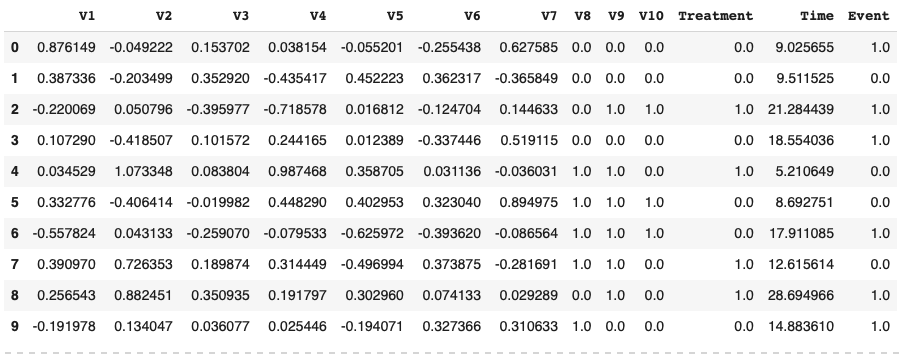

In [ ]:
# Prepare data for running R-learner
data = TrainData

x_dat = tf.convert_to_tensor(TrainData.drop(['Treatment',"Time","Event"],axis=1))
y_dat = tf.convert_to_tensor(TrainData[["Time","Event"]])
trt_dat =tf.convert_to_tensor(TrainData[['Treatment']])

data1 = TrainData[(TrainData['Treatment']==1)]
data0 = TrainData[(TrainData['Treatment']==0)]

# prepare training data for treatment group=1
x_dat1 = tf.convert_to_tensor(data1.drop(['Treatment',"Time","Event"],axis=1))
y_dat1 = tf.convert_to_tensor(data1[["Time","Event"]])

# prepare training data for treatment group=0
x_dat0 = tf.convert_to_tensor(data0.drop(['Treatment',"Time","Event"],axis=1))
y_dat0 = tf.convert_to_tensor(data0[["Time","Event"]])

# R-learner

Fit Cox NN using Cox partial likelihood with Efron's approximation using all subjects (regardless of treatment).

Alternatively, you can run NN on each treatment arm and use propensity score to combine.

In [ ]:
### set up DNN parameters ###
num_nodes = 30             # number of nodes per hidden layer
string_activation = "selu" # activation function
num_l1 = 0.1               # L1 penalty
num_lr = 0.01              # learning rate
num_epoch = 80             # number of epoches for optimization
batch_size = 50            # number of batch size for optimization

In [ ]:
#-------------------- Fit DNNsurv using all subjects (~20min) ----------------------#
tf.config.run_functions_eagerly(True)
#clear the previous model
tfkb.clear_session()

# define the keras model
model1 = Sequential()
model1.add(Dense(num_nodes, input_dim=x_dat.shape[1], activation=string_activation,kernel_regularizer=regularizers.l1(num_l1)))
model1.add(Dense(num_nodes, activation=string_activation,kernel_regularizer=regularizers.l1(num_l1)))
model1.add(Dense(1, activation=string_activation))

# compile the keras model
opt = RMSprop(learning_rate = num_lr)
model1.compile(
    loss      = loss_lik_efron,
    optimizer = opt,
    metrics   = None,
    run_eagerly=True
)

# fit the keras model on the training set
history1=model1.fit(x_dat, y_dat,
                    epochs=num_epoch,
                    batch_size=batch_size,
                    verbose = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 133.0479
Epoch 2/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 579ms/step - loss: 117.8199
Epoch 3/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - loss: 112.0430
Epoch 4/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - loss: 111.1511
Epoch 5/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 587ms/step - loss: 109.9778
Epoch 6/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - loss: 109.2118
Epoch 7/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 609ms/step - loss: 109.3364
Epoch 8/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 546ms/step - loss: 105.5316
Epoch 9/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 560ms/step - loss: 105.4122
Epoch 10/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - loss: 103.9034
Epoch 11/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 586ms/step - loss: 107.5309
Epoch 12/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - loss: 109.1329
Epoch 13/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - loss: 108.8457
Epoch 14/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 563ms/step - loss: 106.2343
Epoch 15/80
20/20 

In [ ]:
# plot loss
plt.plot(history1.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Predict survival probability for each subejct:

In [ ]:
# predict prognostic index
y_dat_pred = model1.predict(x_dat)

# baseline cumulative hazard
baseline1 = base_efron(y_test=y_dat, y_test_pred=y_dat_pred)
Lambda_t1 = baseline1['cumhazard'][np.max(np.where(baseline1['time'] <= time_interest))]

# Predict survival probability
TrainData['S_x'] = np.exp(-1 * np.outer(np.exp(y_dat_pred),Lambda_t1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Fit propensity model of treatment assignment (using random forests here as an example):

In [ ]:
cols = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10"]
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_leaf=5,max_features=1/3)
rf.fit(TrainData[cols],TrainData['Treatment'])
TrainData['propensity'] = rf.predict_proba(TrainData[cols])[:,1] # predicted propensity score on training data

Construct $Y^*$:

In [ ]:
# calculate Y* for those whose I(T>t*) can be defined.
TrainData['Surv'] = np.where((TrainData['Time'] >= time_interest), 1,
                         np.where((TrainData['Time'] < time_interest) & (TrainData['Event'] == 1), 0, np.nan))

TrainData['pseudo'] = (TrainData['Surv'] - TrainData['S_x']) / (TrainData['Treatment'] - TrainData['propensity'])

Calculate IPCW using KM:

In [ ]:
# model censoring probability using KM
U = np.minimum(data['Time'], time_interest)

k_folds=4

fold_id = np.random.choice(np.repeat(np.arange(1, k_folds + 1), len(data)), len(data))
C_hat = np.full(len(fold_id), np.nan)

for z in range(1, k_folds + 1):
    censored_data = data[fold_id != z]
    c_fit = KaplanMeierFitter().fit(durations=censored_data['Time'], event_observed=1 - censored_data['Event'])
    kmc = c_fit.survival_function_at_times(U[fold_id == z])
    C_hat[fold_id == z] = kmc.values[0]

TrainData['C_hat'] = C_hat

Construct weight:

In [ ]:
TrainData['weight'] = (1.0 / TrainData['C_hat']) * ( (TrainData['Treatment'] - TrainData['propensity']) ** 2 )

In [ ]:
TrainData

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Treatment,Time,Event,S_x,propensity,Surv,pseudo,C_hat,weight
0,0.876149,-0.049222,0.153702,0.038154,-0.055201,-0.255438,0.627585,0.0,0.0,0.0,0.0,9.025655,1.0,0.704421,0.291750,0.0,2.414467,0.846961,0.100498
1,0.387336,-0.203499,0.352920,-0.435417,0.452223,0.362317,-0.365849,0.0,0.0,0.0,0.0,9.511525,0.0,0.662728,0.381910,NaN,NaN,0.846961,0.172210
2,-0.220069,0.050796,-0.395977,-0.718578,0.016812,-0.124704,0.144633,0.0,1.0,1.0,1.0,21.284439,1.0,0.664939,0.695885,1.0,1.101755,0.795388,0.116278
3,0.107290,-0.418507,0.101572,0.244165,0.012389,-0.337446,0.519115,0.0,0.0,0.0,0.0,18.554036,1.0,0.639711,0.333546,1.0,-1.080177,0.819416,0.135771
4,0.034529,1.073348,0.083804,0.987468,0.358705,0.031136,-0.036031,1.0,1.0,0.0,1.0,5.210649,0.0,0.705422,0.685682,NaN,NaN,0.795388,0.124211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.036531,-0.179586,-0.473838,-0.622687,-0.060341,0.276445,-0.291488,0.0,0.0,1.0,1.0,8.477605,1.0,0.659163,0.653734,0.0,-1.903632,0.819416,0.146324
996,0.326702,-0.501710,0.059423,-0.077390,0.154219,0.414462,-0.462921,0.0,1.0,0.0,1.0,14.303128,1.0,0.465022,0.726280,1.0,1.954471,0.795388,0.094196
997,-0.506061,-0.535121,0.096877,0.256630,0.436977,-0.103060,0.195598,0.0,0.0,0.0,0.0,15.491819,0.0,0.550418,0.291390,1.0,-1.542888,0.819416,0.103620
998,0.181916,0.124582,0.026749,-0.229107,-0.625094,-0.212335,0.551621,0.0,0.0,0.0,0.0,9.062063,1.0,0.705567,0.329064,0.0,2.144163,0.816515,0.132616


Perform regression to estimate CATE (using grandient boosting as an example here):

In [ ]:
params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'min_samples_leaf': round(959/100),
    'subsample': 0.5,
    'loss': 'ls'
}

reg1 = GradientBoostingRegressor(
       loss='squared_error',   # replaces 'ls'
       learning_rate=0.1,      # (or whatever you were using)
       n_estimators=100,       # adjust as needed
       max_depth=3,            # etc.
       random_state=42
)

mask = ~np.isnan(TrainData['Surv'])
data_reg = TrainData.loc[mask,cols]
pseudo = TrainData.loc[mask,"pseudo"]
sample_weight = TrainData.loc[mask,"weight"]
reg1.fit(data_reg, pseudo, sample_weight=sample_weight)

preddiff = reg1.predict(TestData[cols])

Distribution of predicted CATEs:

(array([3.000e+00, 1.000e+00, 4.000e+00, 1.200e+01, 3.400e+01, 5.800e+01,
        7.800e+01, 1.230e+02, 1.510e+02, 2.490e+02, 3.690e+02, 5.930e+02,
        7.000e+02, 7.900e+02, 7.920e+02, 1.005e+03, 1.284e+03, 1.233e+03,
        1.005e+03, 6.540e+02, 4.210e+02, 2.130e+02, 1.070e+02, 6.200e+01,
        3.200e+01, 1.400e+01, 7.000e+00, 3.000e+00, 1.000e+00, 2.000e+00]),
 array([-1.99568771, -1.85729932, -1.71891093, -1.58052254, -1.44213415,
        -1.30374576, -1.16535737, -1.02696898, -0.88858059, -0.7501922 ,
        -0.61180381, -0.47341542, -0.33502703, -0.19663864, -0.05825024,
         0.08013815,  0.21852654,  0.35691493,  0.49530332,  0.63369171,
         0.7720801 ,  0.91046849,  1.04885688,  1.18724527,  1.32563366,
         1.46402205,  1.60241044,  1.74079883,  1.87918722,  2.01757561,
         2.155964  ]),
 <BarContainer object of 30 artists>)

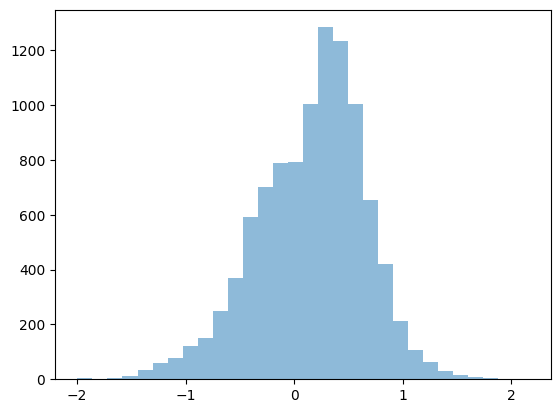

In [ ]:
plt.hist(preddiff, bins=30, alpha=0.5, label='Predicted')